In [1]:
import os
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

# torchvision
import torchvision
import module_lsq as Q
from models.model import create_model
from configs import *

from xlwt import Workbook
import copy
import numpy as np
from utils import *
from functools import partial

import math
import time
import warnings

import matplotlib.pyplot as plt

# 1. LSQのチェック

1. activationのgrad scale on/off

In [9]:
dir_name_w_GS = "./work_dir/imagenet/LSQ/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_w_GS_mean_file_name = dir_name_w_GS + "Ax_mean.pt"
A_w_GS_std_file_name = dir_name_w_GS + "Ax_std.pt"

dir_name_wo_GS = "./work_dir/imagenet/LSQ/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_wo_grad_scale-2/"
A_wo_GS_mean_file_name = dir_name_wo_GS + "Ax_mean.pt"
A_wo_GS_std_file_name = dir_name_wo_GS + "Ax_std.pt"

In [10]:
A_w_GS_mean = torch.load(A_w_GS_mean_file_name)
A_w_GS_std = torch.load(A_w_GS_std_file_name)
A_wo_GS_mean = torch.load(A_wo_GS_mean_file_name)
A_wo_GS_std = torch.load(A_wo_GS_std_file_name)

In [11]:
A_w_GS_mean_plt = torch.reshape(A_w_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wo_GS_mean_plt = torch.reshape(A_wo_GS_mean, (-1,)).to('cpu').detach().numpy().copy()

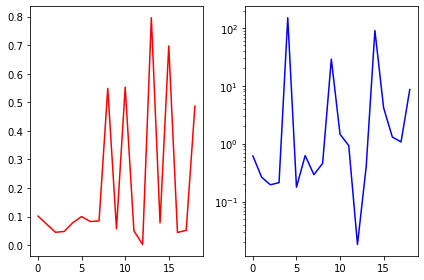

In [12]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_w_GS_mean_plt,color="red")
axes[0,1].plot(A_wo_GS_mean_plt,color="blue")
axes[0,1].set_yscale('log')

plt.show()

1'. actのgrad scale on/offで学習自体はgrad scale on

In [19]:
dir_name_w_GS = "./work_dir/imagenet/LSQ/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_x_GS_mean_file_name = dir_name_w_GS + "Ax_mean.pt"
A_x_GS_std_file_name = dir_name_w_GS + "Ax_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_x.pt"

In [20]:
A_x_GS_mean = torch.load(A_x_GS_mean_file_name)
A_x_GS_std = torch.load(A_x_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [21]:
print(A_x_GS_mean.size())
print(grad_scale.size())
A_x_GS_mean = A_x_GS_mean.to('cpu')
A_x_woGS_mean = torch.zeros_like(A_x_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_x_GS_mean.size(1)):
    A_x_woGS_mean[:,i] = A_x_GS_mean[:,i]/grad_scale



torch.Size([19, 1])
torch.Size([19])


In [22]:
A_x_GS_mean_plt = torch.reshape(A_x_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_x_wo_GS_mean_plt = torch.reshape(A_x_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

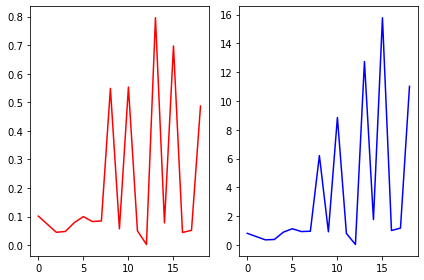

In [23]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_x_GS_mean_plt,color="red")
axes[0,1].plot(A_x_wo_GS_mean_plt,color="blue")
plt.show()

In [25]:
A_x_GS_mean_plt

array([0.10182024, 0.07341176, 0.04523169, 0.04809145, 0.07919057,
       0.1000304 , 0.08283661, 0.08484149, 0.54894376, 0.05736364,
       0.5533799 , 0.05037274, 0.00257209, 0.79616636, 0.07825508,
       0.69739425, 0.04466372, 0.05198213, 0.48704013], dtype=float32)

In [24]:
grad_scale

tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.0884, 0.0884, 0.0884, 0.0884, 0.0884,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0442, 0.0442, 0.0442, 0.0442,
        0.0442])

In [26]:
A_x_wo_GS_mean_plt

array([ 0.8145619 ,  0.58729404,  0.3618535 ,  0.3847316 ,  0.895939  ,
        1.1317148 ,  0.9371893 ,  0.9598719 ,  6.21059   ,  0.9178182 ,
        8.854078  ,  0.8059639 ,  0.04115347, 12.738662  ,  1.7707103 ,
       15.7802305 ,  1.0106245 ,  1.1762213 , 11.02046   ], dtype=float32)

1.の結果は何かおかしくて、こちらの方が自然

2. weightのgrad scale on/off

In [123]:
dir_name_w_GS = "./work_dir/imagenet/LSQ/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_w_GS_mean_file_name = dir_name_w_GS + "Aw_mean.pt"
A_w_GS_std_file_name = dir_name_w_GS + "Aw_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_w.pt"

In [124]:
A_w_GS_mean = torch.load(A_w_GS_mean_file_name)
A_w_GS_std = torch.load(A_w_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [125]:
print(A_w_GS_mean.size())
print(grad_scale.size())
A_w_GS_mean = A_w_GS_mean.to('cpu')
A_woGS_mean = torch.zeros_like(A_w_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_w_GS_mean.size(1)):
    A_woGS_mean[:,i] = A_w_GS_mean[:,i]/grad_scale

A_w_GS_mean = A_w_GS_mean.to('cpu')
A_woGS_mean = torch.zeros_like(A_w_GS_mean)
for i in range(A_w_GS_mean.size(1)):
    A_woGS_mean[:,i] = A_w_GS_mean[:,i]/grad_scale


torch.Size([19, 1])
torch.Size([19])


In [126]:
A_x_w_GS_mean_plt = torch.reshape(A_w_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_x_wo_GS_mean_plt = torch.reshape(A_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

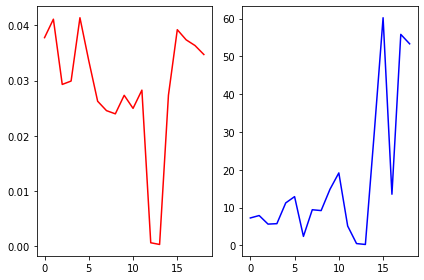

In [131]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_x_w_GS_mean_plt,color="red")
axes[0,1].plot(A_x_wo_GS_mean_plt,color="blue")
plt.show()

# 2. nuLSQのチェック

1'. actのgrad scale on/offで学習自体はgrad scale on

In [27]:
dir_name_w_GS = "./work_dir/imagenet/LSQ_non_uniform_only_activation/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_x_GS_mean_file_name = dir_name_w_GS + "Ax_mean.pt"
A_x_GS_std_file_name = dir_name_w_GS + "Ax_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_x.pt"

In [28]:
A_x_GS_mean = torch.load(A_x_GS_mean_file_name)
A_x_GS_std = torch.load(A_x_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [29]:
print(A_x_GS_mean.size())
print(grad_scale.size())
A_x_GS_mean = A_x_GS_mean.to('cpu')
A_x_woGS_mean = torch.zeros_like(A_x_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_x_GS_mean.size(1)):
    A_x_woGS_mean[:,i] = A_x_GS_mean[:,i]/grad_scale


torch.Size([19, 3])
torch.Size([19])


In [30]:
A_x_GS_mean_plt = torch.reshape(A_x_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_x_wo_GS_mean_plt = torch.reshape(A_x_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

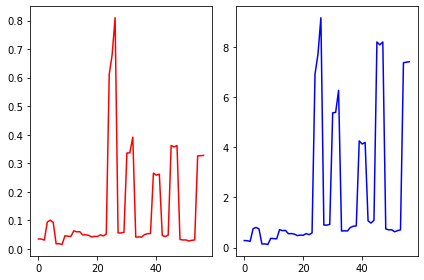

In [31]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_x_GS_mean_plt,color="red")
axes[0,1].plot(A_x_wo_GS_mean_plt,color="blue")
plt.show()

1''. actのgrad scale on/offで学習自体はgrad scale on@lr=0.001

In [54]:
dir_name_w_GS = "./work_dir/imagenet/LSQ_non_uniform_only_activation/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.001_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_x_GS_mean_file_name = dir_name_w_GS + "Ax_mean.pt"
A_x_GS_std_file_name = dir_name_w_GS + "Ax_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_x.pt"

In [55]:
A_x_GS_mean = torch.load(A_x_GS_mean_file_name)
A_x_GS_std = torch.load(A_x_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [56]:
print(A_x_GS_mean.size())
print(grad_scale.size())
A_x_GS_mean = A_x_GS_mean.to('cpu')
A_x_woGS_mean = torch.zeros_like(A_x_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_x_GS_mean.size(1)):
    A_x_woGS_mean[:,i] = A_x_GS_mean[:,i]/grad_scale


torch.Size([19, 3])
torch.Size([19])


In [57]:
A_x_GS_mean_plt = torch.reshape(A_x_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_x_wo_GS_mean_plt = torch.reshape(A_x_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

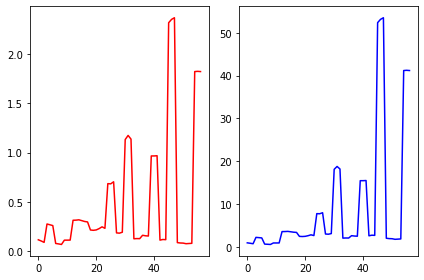

In [58]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_x_GS_mean_plt,color="red")
axes[0,1].plot(A_x_wo_GS_mean_plt,color="blue")
plt.show()

1''. actのgrad scale on/offで学習自体はgrad scale on lr=0.01かつ両方nuLSQのケース 500 iter

In [100]:
dir_name_w_GS = "./work_dir/imagenet/LSQ_non_uniform_both_activation_weight/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_x_GS_mean_file_name = dir_name_w_GS + "Ax_mean.pt"
A_x_GS_std_file_name = dir_name_w_GS + "Ax_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_x.pt"

In [101]:
A_x_GS_mean = torch.load(A_x_GS_mean_file_name)
A_x_GS_std = torch.load(A_x_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [102]:
print(A_x_GS_mean.size())
print(grad_scale.size())
A_x_GS_mean = A_x_GS_mean.to('cpu')
A_x_woGS_mean = torch.zeros_like(A_x_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_x_GS_mean.size(1)):
    A_x_woGS_mean[:,i] = A_x_GS_mean[:,i]/grad_scale


torch.Size([19, 3])
torch.Size([19])


In [103]:
A_x_GS_mean_plt = torch.reshape(A_x_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_x_wo_GS_mean_plt = torch.reshape(A_x_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

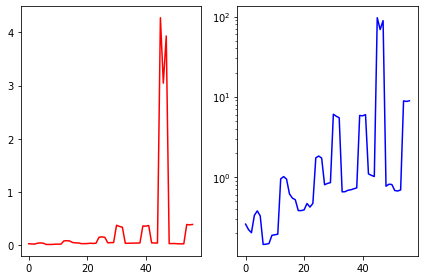

In [104]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_x_GS_mean_plt,color="red")
axes[0,1].plot(A_x_wo_GS_mean_plt,color="blue")
axes[0,1].set_yscale('log')
plt.show()

1''. actのgrad scale on/offで学習自体はgrad scale on lr=0.001かつ両方nuLSQのケース

In [75]:
dir_name_w_GS = "./work_dir/imagenet/LSQ_non_uniform_both_activation_weight/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.001_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_x_GS_mean_file_name = dir_name_w_GS + "Ax_mean.pt"
A_x_GS_std_file_name = dir_name_w_GS + "Ax_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_x.pt"

In [76]:
A_x_GS_mean = torch.load(A_x_GS_mean_file_name)
A_x_GS_std = torch.load(A_x_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [77]:
print(A_x_GS_mean.size())
print(grad_scale.size())
A_x_GS_mean = A_x_GS_mean.to('cpu')
A_x_woGS_mean = torch.zeros_like(A_x_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_x_GS_mean.size(1)):
    A_x_woGS_mean[:,i] = A_x_GS_mean[:,i]/grad_scale


torch.Size([19, 3])
torch.Size([19])


In [78]:
A_x_GS_mean_plt = torch.reshape(A_x_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_x_wo_GS_mean_plt = torch.reshape(A_x_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

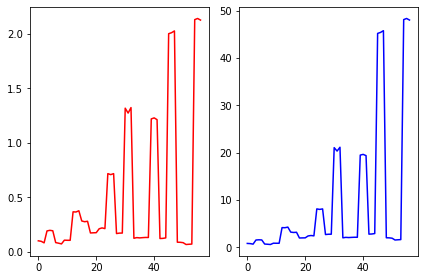

In [79]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(1,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_x_GS_mean_plt,color="red")
axes[0,1].plot(A_x_wo_GS_mean_plt,color="blue")
plt.show()

2. weightのgrad scale on/off@lr=0.01かつ500 iter

In [105]:
dir_name_w_GS = "./work_dir/imagenet/LSQ_non_uniform_both_activation_weight/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.01_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_wneg_GS_mean_file_name = dir_name_w_GS + "Awneg_mean.pt"
A_wneg_GS_std_file_name = dir_name_w_GS + "Awneg_std.pt"
A_wpos_GS_mean_file_name = dir_name_w_GS + "Awpos_mean.pt"
A_wpos_GS_std_file_name = dir_name_w_GS + "Awpos_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_w.pt"

In [106]:
A_wneg_GS_mean = torch.load(A_wneg_GS_mean_file_name)
A_wneg_GS_std = torch.load(A_wneg_GS_std_file_name)
A_wpos_GS_mean = torch.load(A_wpos_GS_mean_file_name)
A_wpos_GS_std = torch.load(A_wpos_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [107]:
print(A_wneg_GS_mean.size())
A_wneg_GS_mean = A_wneg_GS_mean.to('cpu')
A_wneg_woGS_mean = torch.zeros_like(A_wneg_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_wneg_GS_mean.size(1)):
    A_wneg_woGS_mean[:,i] = A_wneg_GS_mean[:,i]/grad_scale

A_wpos_GS_mean = A_wpos_GS_mean.to('cpu')
A_wpos_woGS_mean = torch.zeros_like(A_wpos_GS_mean)
for i in range(A_wpos_GS_mean.size(1)):
    A_wpos_woGS_mean[:,i] = A_wpos_GS_mean[:,i]/grad_scale


torch.Size([19, 2])


In [108]:
A_wpos_GS_mean_plt = torch.reshape(A_wpos_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wpos_wo_GS_mean_plt = torch.reshape(A_wpos_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wneg_GS_mean_plt = torch.reshape(A_wneg_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wneg_wo_GS_mean_plt = torch.reshape(A_wneg_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

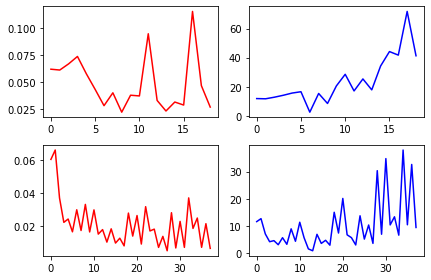

In [109]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(2,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_wpos_GS_mean_plt,color="red")
axes[0,1].plot(A_wpos_wo_GS_mean_plt,color="blue")
axes[1,0].plot(A_wneg_GS_mean_plt,color="red")
axes[1,1].plot(A_wneg_wo_GS_mean_plt,color="blue")
plt.show()

In [111]:
print(A_wpos_GS_mean)

tensor([[0.0619],
        [0.0612],
        [0.0669],
        [0.0737],
        [0.0578],
        [0.0432],
        [0.0282],
        [0.0401],
        [0.0222],
        [0.0379],
        [0.0372],
        [0.0947],
        [0.0331],
        [0.0233],
        [0.0316],
        [0.0288],
        [0.1154],
        [0.0468],
        [0.0269]], grad_fn=<ToCopyBackward0>)


In [112]:
print(A_wpos_woGS_mean)

tensor([[11.8943],
        [11.7460],
        [12.8432],
        [14.1584],
        [15.6816],
        [16.6015],
        [ 2.5530],
        [15.4069],
        [ 8.5285],
        [20.5730],
        [28.5873],
        [17.1502],
        [25.3943],
        [17.8859],
        [34.2968],
        [44.2127],
        [41.7753],
        [71.8089],
        [41.3243]], grad_fn=<CopySlices>)


In [113]:
grad_scale 

tensor([0.0052, 0.0052, 0.0052, 0.0052, 0.0037, 0.0026, 0.0110, 0.0026, 0.0026,
        0.0018, 0.0013, 0.0055, 0.0013, 0.0013, 0.0009, 0.0007, 0.0028, 0.0007,
        0.0007])

2. weightのgrad scale on/off

In [90]:
dir_name_w_GS = "./work_dir/imagenet/LSQ_non_uniform_both_activation_weight/calculate_A_preresnet18_2bit_SGD_CosineAnnealing_lr0.001_wo_wd_for_scale_w_LSQ_grad_scale_x_LSQ_grad_scale-2/"
A_wneg_GS_mean_file_name = dir_name_w_GS + "Awneg_mean.pt"
A_wneg_GS_std_file_name = dir_name_w_GS + "Awneg_std.pt"
A_wpos_GS_mean_file_name = dir_name_w_GS + "Awpos_mean.pt"
A_wpos_GS_std_file_name = dir_name_w_GS + "Awpos_std.pt"
grad_scale_file_name = dir_name_w_GS + "grad_LSQ_w.pt"

In [91]:
A_wneg_GS_mean = torch.load(A_wneg_GS_mean_file_name)
A_wneg_GS_std = torch.load(A_wneg_GS_std_file_name)
A_wpos_GS_mean = torch.load(A_wpos_GS_mean_file_name)
A_wpos_GS_std = torch.load(A_wpos_GS_std_file_name)
grad_scale = torch.load(grad_scale_file_name)

In [92]:
print(A_wneg_GS_mean.size())
A_wneg_GS_mean = A_wneg_GS_mean.to('cpu')
A_wneg_woGS_mean = torch.zeros_like(A_wneg_GS_mean)
# num =A_wneg_GS_mean.size(1)
for i in range(A_wneg_GS_mean.size(1)):
    A_wneg_woGS_mean[:,i] = A_wneg_GS_mean[:,i]/grad_scale

A_wpos_GS_mean = A_wpos_GS_mean.to('cpu')
A_wpos_woGS_mean = torch.zeros_like(A_wpos_GS_mean)
for i in range(A_wpos_GS_mean.size(1)):
    A_wpos_woGS_mean[:,i] = A_wpos_GS_mean[:,i]/grad_scale


torch.Size([19, 2])


In [93]:
A_wpos_GS_mean_plt = torch.reshape(A_wpos_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wpos_wo_GS_mean_plt = torch.reshape(A_wpos_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wneg_GS_mean_plt = torch.reshape(A_wneg_GS_mean, (-1,)).to('cpu').detach().numpy().copy()
A_wneg_wo_GS_mean_plt = torch.reshape(A_wneg_woGS_mean, (-1,)).to('cpu').detach().numpy().copy()

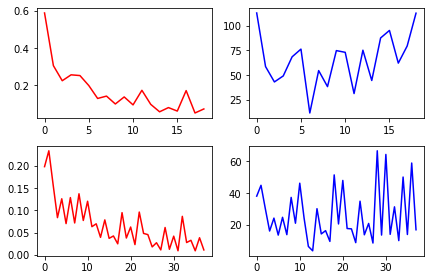

In [94]:
# plt.plot(A_w_GS_mean_plt)
# plt.plot(A_wo_GS_mean_plt)
fig, axes=plt.subplots(2,2,squeeze=False, tight_layout = True)
axes[0,0].plot(A_wpos_GS_mean_plt,color="red")
axes[0,1].plot(A_wpos_wo_GS_mean_plt,color="blue")
axes[1,0].plot(A_wneg_GS_mean_plt,color="red")
axes[1,1].plot(A_wneg_wo_GS_mean_plt,color="blue")
plt.show()